In [218]:
#필요한 라이브러리 import 하기
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

#데이터 가지고 오기

train = pd.read_csv("./data/train.csv")
test = pd.read_csv("./data/test.csv")

In [219]:
#데이터 형태 확인
print(train.shape)
print(test.shape)

(15035, 21)
(6468, 20)


In [220]:
#데이터 구성 확인
train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [188]:
#결측치 확인
train.isnull().any(axis=1)
test.isnull().any(axis=1)

0       False
1       False
2       False
3       False
4       False
        ...  
6463    False
6464    False
6465    False
6466    False
6467    False
Length: 6468, dtype: bool

In [221]:
#x,y 분리 y에 price 저장
y= train['price']
del train['price']


In [222]:
train.head()

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [223]:
#중복 데이터 확인
train[train.duplicated()]

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15


In [224]:
print(train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15035 entries, 0 to 15034
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             15035 non-null  int64  
 1   date           15035 non-null  object 
 2   bedrooms       15035 non-null  int64  
 3   bathrooms      15035 non-null  float64
 4   sqft_living    15035 non-null  int64  
 5   sqft_lot       15035 non-null  int64  
 6   floors         15035 non-null  float64
 7   waterfront     15035 non-null  int64  
 8   view           15035 non-null  int64  
 9   condition      15035 non-null  int64  
 10  grade          15035 non-null  int64  
 11  sqft_above     15035 non-null  int64  
 12  sqft_basement  15035 non-null  int64  
 13  yr_built       15035 non-null  int64  
 14  yr_renovated   15035 non-null  int64  
 15  zipcode        15035 non-null  int64  
 16  lat            15035 non-null  float64
 17  long           15035 non-null  float64
 18  sqft_l

In [225]:
train['date'] = pd.to_datetime(train.date)

In [226]:
#date 항목을 년,월,일로 분할
train["year"] = train['date'].dt.year
train["month"] = train['date'].dt.month
train["day"] = train['date'].dt.day

In [227]:
del train['date']
del test['date']

In [228]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15035 entries, 0 to 15034
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             15035 non-null  int64  
 1   bedrooms       15035 non-null  int64  
 2   bathrooms      15035 non-null  float64
 3   sqft_living    15035 non-null  int64  
 4   sqft_lot       15035 non-null  int64  
 5   floors         15035 non-null  float64
 6   waterfront     15035 non-null  int64  
 7   view           15035 non-null  int64  
 8   condition      15035 non-null  int64  
 9   grade          15035 non-null  int64  
 10  sqft_above     15035 non-null  int64  
 11  sqft_basement  15035 non-null  int64  
 12  yr_built       15035 non-null  int64  
 13  yr_renovated   15035 non-null  int64  
 14  zipcode        15035 non-null  int64  
 15  lat            15035 non-null  float64
 16  long           15035 non-null  float64
 17  sqft_living15  15035 non-null  int64  
 18  sqft_l

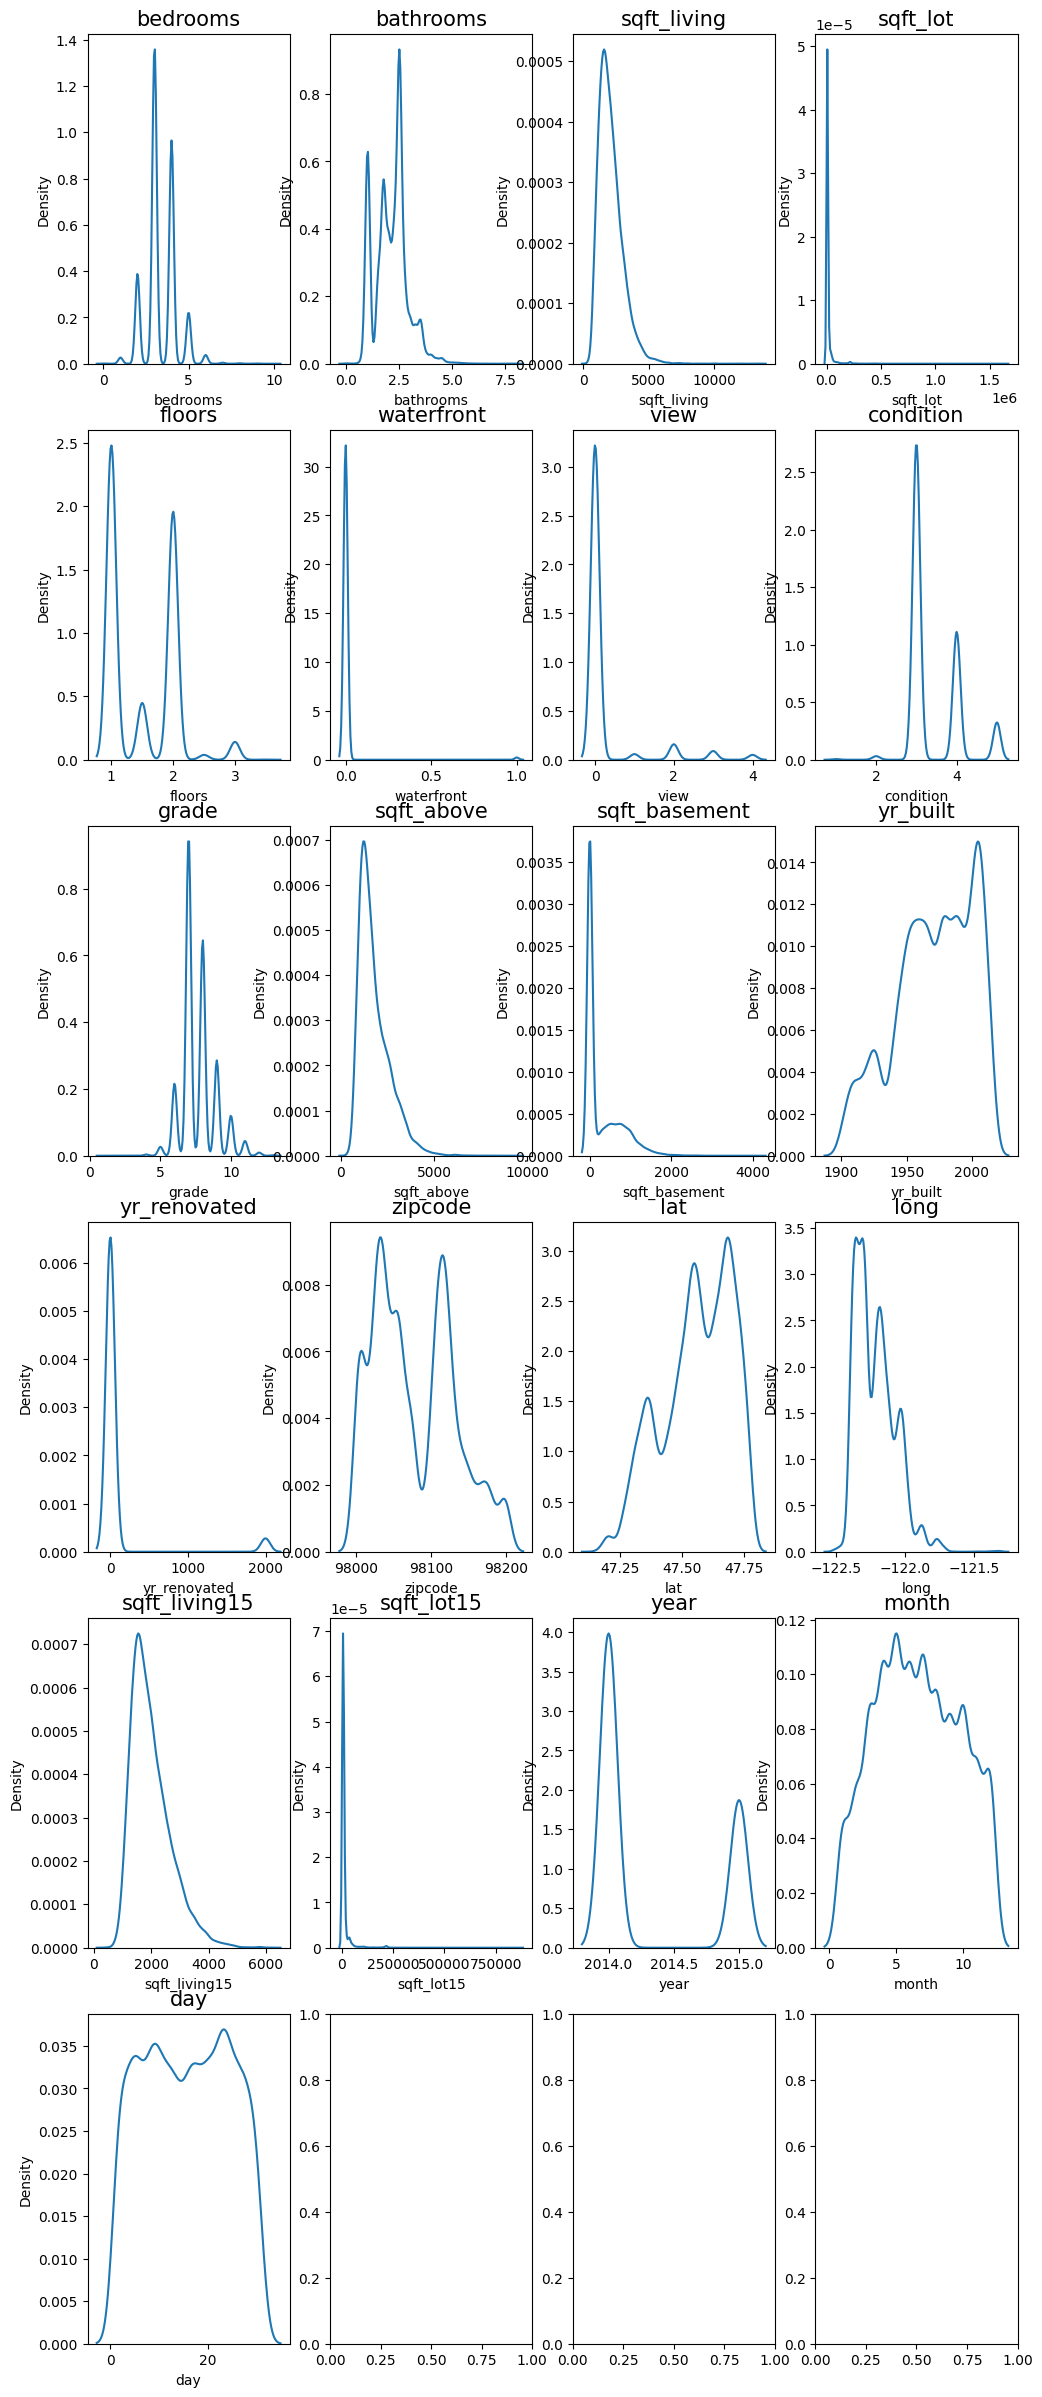

In [229]:
fig, ax = plt.subplots(6, 4, figsize=(12, 30))

# id 변수(count==0인 경우)는 제외하고 분포를 확인합니다.
count = 1
columns = train.columns
for row in range(6):
    for col in range(4):
        sns.kdeplot(data=train[columns[count]], ax=ax[row][col])
        ax[row][col].set_title(columns[count], fontsize=15)
        count += 1
        if count == 22 :
            break

bedrooms, sqft_living, sqft_lot,waterfront,wiew, sqft_above, sqft_basement, sqft_living15, sqft_lot15 변수가 한쪽으로 치우친 경향을 보였습니다.
log-scaling(로그 변환)을 통해 데이터 분포를 정규분포에 가깝게 만들어 보겠습니다.

In [230]:
skew_columns = ['bedrooms', 'sqft_living', 'sqft_lot', 'waterfront','view','sqft_above', 'sqft_basement', 'sqft_lot15', 'sqft_living15']

for c in skew_columns:
    train[c] = np.log1p(train[c].values)

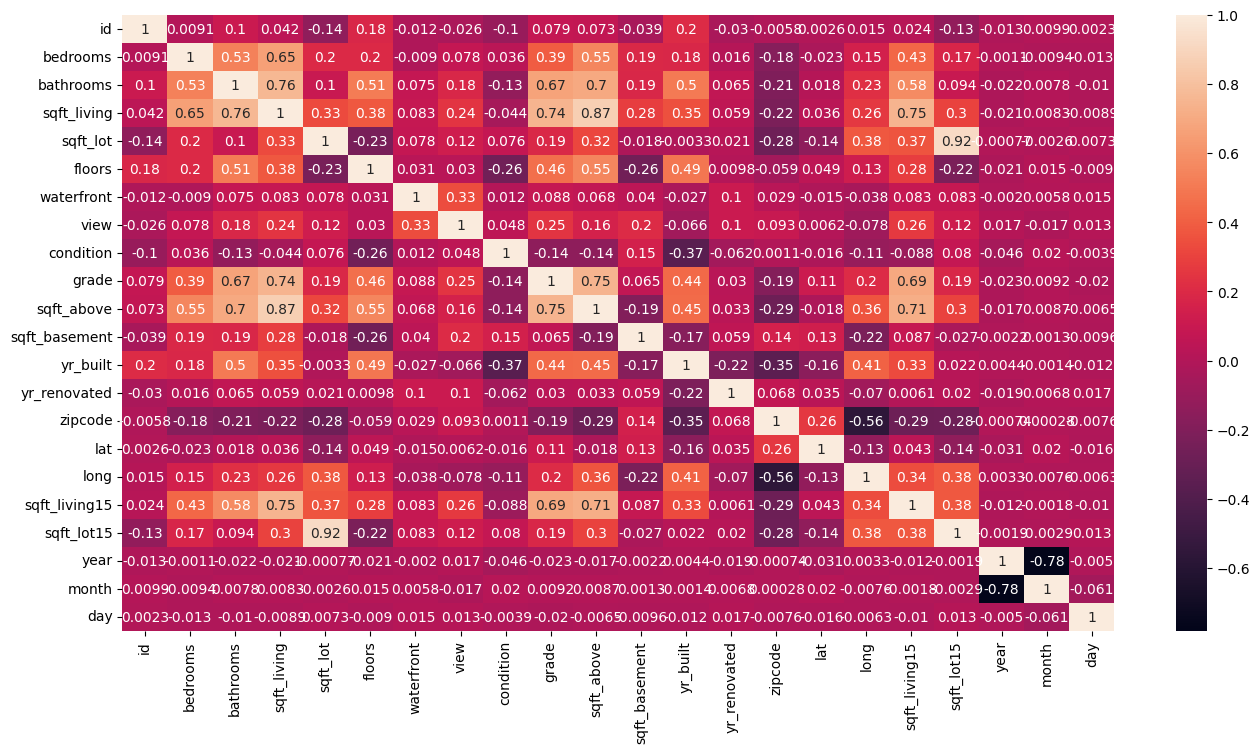

In [231]:
#각각의 컬럼들 간의 상관계수를 heatmap을 통해 시각화
plt.figure(figsize=(16,8))
sns.heatmap(train.corr(), annot=True)
plt.show()

In [232]:
#x와 y값의 상관관계 분석
for i in train.columns:
  print("corr",i,np.corrcoef(train[i],y))


corr id [[1.        0.0208986]
 [0.0208986 1.       ]]
corr bedrooms [[1.         0.31168565]
 [0.31168565 1.        ]]
corr bathrooms [[1.         0.52547945]
 [0.52547945 1.        ]]
corr sqft_living [[1.         0.60985715]
 [0.60985715 1.        ]]
corr sqft_lot [[1.         0.16685132]
 [0.16685132 1.        ]]
corr floors [[1.         0.26258787]
 [0.26258787 1.        ]]
corr waterfront [[1.         0.26573832]
 [0.26573832 1.        ]]
corr view [[1.         0.38894368]
 [0.38894368 1.        ]]
corr condition [[1.        0.0397398]
 [0.0397398 1.       ]]
corr grade [[1.         0.66721077]
 [0.66721077 1.        ]]
corr sqft_above [[1.         0.54295917]
 [0.54295917 1.        ]]
corr sqft_basement [[1.         0.20463993]
 [0.20463993 1.        ]]
corr yr_built [[1.         0.04729033]
 [0.04729033 1.        ]]
corr yr_renovated [[1.         0.14080798]
 [0.14080798 1.        ]]
corr zipcode [[ 1.         -0.05149843]
 [-0.05149843  1.        ]]
corr lat [[1.         0.301

In [233]:
#상관계수와 캐글에 있는 각 feature 특성을 보고 feature를 일부 모아서 학습에 활용
train_1=train[['bedrooms','bathrooms','sqft_living','view','grade','condition','sqft_above','sqft_living15','sqft_lot15','sqft_basement','lat','floors','waterfront','yr_renovated','sqft_lot' ]]
test_1=test[['bedrooms','bathrooms','sqft_living','view','grade','condition','sqft_above','sqft_living15','sqft_lot15','sqft_basement','lat','floors','waterfront','yr_renovated','sqft_lot' ]]
train_1.head(20)

,bedrooms,bathrooms,sqft_living,view,grade,condition,sqft_above,sqft_living15,sqft_lot15,sqft_basement,lat,floors,waterfront,yr_renovated,sqft_lot
0,1.386294,1.00,7.074117,0.000000,7,3,7.074117,7.201171,8.639588,0.000000,47.5112,1.0,0.0,0,8.639588
1,1.098612,1.00,6.647688,0.000000,6,3,6.647688,7.908755,8.995041,0.000000,47.7379,1.0,0.0,0,9.210440
2,1.386294,2.00,7.427144,0.000000,8,3,7.427144,7.496097,8.923191,0.000000,47.6168,1.0,0.0,0,8.997271
3,1.386294,2.25,7.447751,0.000000,7,3,7.447751,7.713785,8.827615,0.000000,47.3097,2.0,0.0,0,8.827615
4,1.386294,1.50,6.966967,0.000000,7,3,6.966967,7.409136,9.181118,0.000000,47.4095,1.0,0.0,0,9.181118
5,1.386294,2.50,8.177797,0.000000,8,3,7.528869,7.701200,9.096724,7.438972,47.6007,1.0,0.0,0,9.189831
6,1.098612,1.00,7.057037,0.000000,7,4,6.758095,7.193686,8.699681,5.707110,47.6900,1.0,0.0,0,8.699681
7,1.386294,1.00,7.266129,0.000000,7,4,7.266129,7.484930,9.449200,0.000000,47.7558,1.5,0.0,0,9.898576
8,1.386294,1.75,7.223296,0.000000,7,4,7.223296,7.223296,9.231025,0.000000,47.6127,1.0,0.0,0,9.177920
9,1.791759,2.00,7.501634,0.000000,7,3,7.501634,7.215975,8.486940,0.000000,47.6700,1.5,0.0,0,8.486940


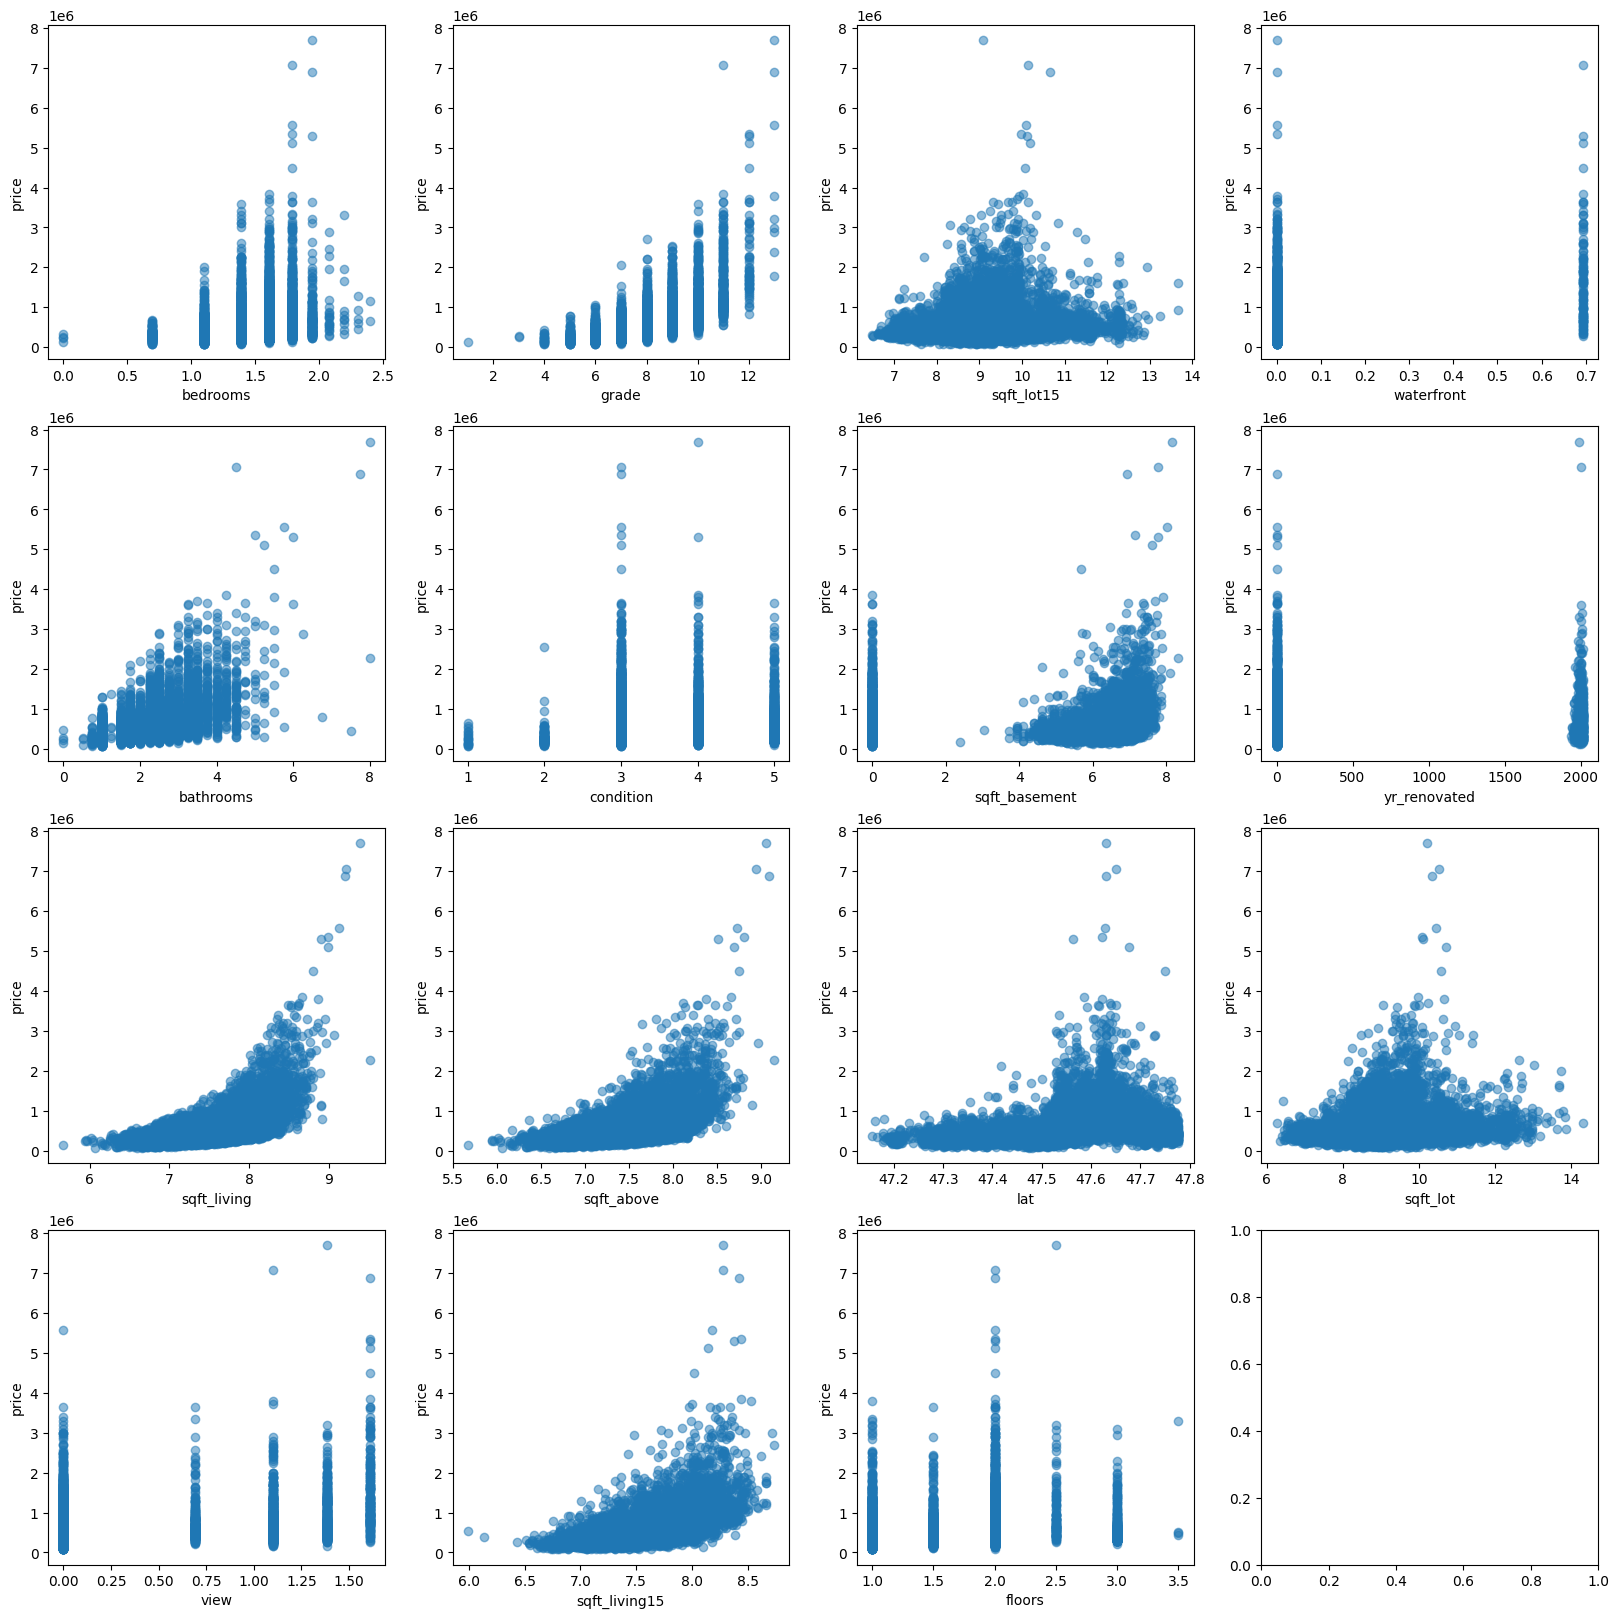

In [234]:
#산점도
import matplotlib.pyplot as plt
fig, axes = plt.subplots(4, 4, figsize=(20, 20))
a,b = 0, 0
for i in train_1.columns:
  if a == 4:
    b=b+1
    a=0
  axes[a, b].scatter(train_1[i], y, alpha=0.5)
  axes[a, b].set_xlabel(i)
  axes[a, b].set_ylabel('price')
  a=a+1
plt.show()

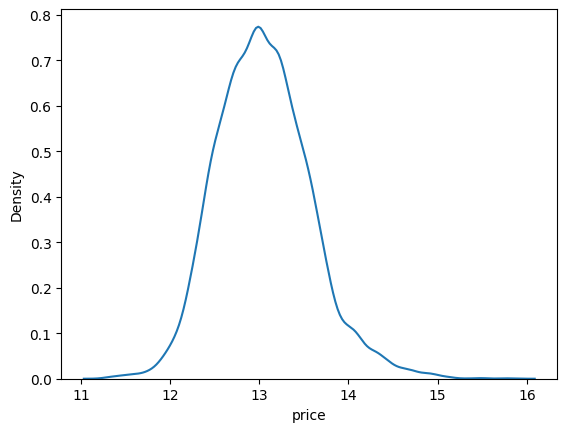

In [235]:
#y를 로그변환 시켜 정규분포 형태로 만든다.
y = np.log1p(y)
y
sns.kdeplot(y)
plt.show()

In [236]:
#필요한 라이브러리를 가져오기
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [237]:
#rmse 함수 구현
#y_test나 y_pred는 위에서 np.log1p()로 변환이 된 값이기 때문에
#원래 데이터의 단위에 맞게 되돌리기 위해 np.expm1()을 추가
def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

lightgbm 파라미터
https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMClassifier.html

In [238]:
from sklearn.model_selection import GridSearchCV

#param_grid에 탐색할 xgboost 관련 하이퍼 파라미터를 넣어서 준비
param_grid = {
    'n_estimators': [80,90, 100,110],
    'max_depth': [8,9,10],
    'learning_rate':[0.01,0.1,0.05],
}

In [239]:
#모델 준비(예시에서는 lightgbm 사용)
from lightgbm import LGBMRegressor
random_state = 2000
model = LGBMRegressor(random_state=random_state)

In [240]:
#다양한 하이퍼 파라미터를 넣어서 학습을 시킨다.
grid_model = GridSearchCV(model, param_grid=param_grid, \
                        scoring='neg_mean_squared_error', \
                        cv=5, verbose=1, n_jobs=5)

grid_model.fit(train_1, y)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


GridSearchCV(cv=5, estimator=LGBMRegressor(random_state=2000), n_jobs=5,
             param_grid={'learning_rate': [0.01, 0.1, 0.05],
                         'max_depth': [8, 9, 10],
                         'n_estimators': [80, 90, 100, 110]},
             scoring='neg_mean_squared_error', verbose=1)

In [241]:
grid_model.cv_results_

{'mean_fit_time': array([1.14489865, 1.07295184, 1.19898   , 1.2320859 , 0.97972918,
        1.06766176, 1.16093807, 1.27604227, 1.29826651, 1.82671194,
        1.64225025, 1.30909557, 0.77744346, 0.84016895, 0.92208843,
        1.02727604, 0.83110833, 0.83657427, 0.91893253, 1.0647779 ,
        1.32903891, 1.60170364, 1.1658051 , 1.05834498, 0.85248966,
        0.97809987, 1.08398561, 1.12084928, 0.91311507, 0.97930923,
        1.0987638 , 1.7812139 , 1.50710564, 1.29955916, 1.09334188,
        0.96631007]),
 'std_fit_time': array([0.08095139, 0.11215305, 0.10018988, 0.14924644, 0.1185543 ,
        0.04671928, 0.05390652, 0.12881107, 0.19998464, 0.13798128,
        0.26082129, 0.13229297, 0.09352604, 0.07885785, 0.06315199,
        0.05491265, 0.07366067, 0.06968358, 0.01850894, 0.17533034,
        0.1376436 , 0.14239655, 0.17786726, 0.05170668, 0.09946169,
        0.08942157, 0.08298977, 0.01506477, 0.0400593 , 0.03996255,
        0.07511179, 0.1909617 , 0.04253377, 0.20499345, 0.087

In [242]:
#필요한 정보만 추출
params = grid_model.cv_results_['params']
print(params)
score = grid_model.cv_results_['mean_test_score']
print(score)

[{'learning_rate': 0.01, 'max_depth': 8, 'n_estimators': 80}, {'learning_rate': 0.01, 'max_depth': 8, 'n_estimators': 90}, {'learning_rate': 0.01, 'max_depth': 8, 'n_estimators': 100}, {'learning_rate': 0.01, 'max_depth': 8, 'n_estimators': 110}, {'learning_rate': 0.01, 'max_depth': 9, 'n_estimators': 80}, {'learning_rate': 0.01, 'max_depth': 9, 'n_estimators': 90}, {'learning_rate': 0.01, 'max_depth': 9, 'n_estimators': 100}, {'learning_rate': 0.01, 'max_depth': 9, 'n_estimators': 110}, {'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 80}, {'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 90}, {'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 100}, {'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 110}, {'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 80}, {'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 90}, {'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 100}, {'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 110}, {'learning_rate

In [243]:
#위에서 뽑은 max_depth,n_estimators,score 데이터프레임으로 묶기
scores = list(score)
for i in range(len(params)):
    params[i]['score'] = scores[i]

results = pd.DataFrame(params)
print(results)

    learning_rate  max_depth  n_estimators     score
0            0.01          8            80 -0.102388
1            0.01          8            90 -0.093227
2            0.01          8           100 -0.085539
3            0.01          8           110 -0.079037
4            0.01          9            80 -0.102377
5            0.01          9            90 -0.093233
6            0.01          9           100 -0.085527
7            0.01          9           110 -0.079027
8            0.01         10            80 -0.102377
9            0.01         10            90 -0.093234
10           0.01         10           100 -0.085528
11           0.01         10           110 -0.079031
12           0.10          8            80 -0.036515
13           0.10          8            90 -0.036423
14           0.10          8           100 -0.036378
15           0.10          8           110 -0.036326
16           0.10          9            80 -0.036492
17           0.10          9            90 -0.

In [244]:
#rmse 추가
results['RMSLE'] = np.sqrt(-1 * results['score'])
results
#RMSLE가 낮은 순서대로 정렬
results.sort_values('RMSLE')

,learning_rate,max_depth,n_estimators,score,RMSLE
19,0.10,9,110,-0.036247,0.190387
18,0.10,9,100,-0.036298,0.190520
15,0.10,8,110,-0.036326,0.190595
14,0.10,8,100,-0.036378,0.190729
17,0.10,9,90,-0.036389,0.190759
13,0.10,8,90,-0.036423,0.190848
23,0.10,10,110,-0.036443,0.190901
22,0.10,10,100,-0.036456,0.190936
21,0.10,10,90,-0.036475,0.190986
16,0.10,9,80,-0.036492,0.191029


In [268]:
#위의 표를 바탕으로 파라미터를 재조정하여 훈련
model = LGBMRegressor(learning_rate=0.1, max_depth=9, n_estimators=110, random_state=random_state)
model.fit(train_1, y)
prediction = model.predict(test_1)
prediction
#예측 결과에 np.expm1()을 씌워서 다시 원래 스케일로 되돌리자
prediction = np.expm1(prediction)
print(prediction)

[ 673489.00380471  664343.44920798 1899743.644473   ...  858232.56235991
  806998.54972142  880686.50191427]


In [269]:
#submission을 가져오자
data_dir = "./data/sample_submission.csv"

submission = pd.read_csv(data_dir)
submission.head()

,id,price
0,15035,100000
1,15036,100000
2,15037,100000
3,15038,100000
4,15039,100000


In [270]:
#submission의 price 값을 예측한 값으로 저장
submission['price'] = prediction
submission.head()

,id,price
0,15035,6.734890e+05
1,15036,6.643434e+05
2,15037,1.899744e+06
3,15038,5.339187e+05
4,15039,5.844393e+05


In [267]:
#파일 이름에 모델의 종류와 위에서 확인했던 RMSLE 값을 입력
submission_csv_path = './data/submission_{}_RMSLE_{}.csv'.format('lgbm', 0.190387)
submission.to_csv(submission_csv_path, index=False)
print(submission_csv_path)

/content/submission_lgbm_RMSLE_0.190387.csv
